In [65]:
!pip install folktables

You should consider upgrading via the '/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/bin/python -m pip install --upgrade pip' command.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from utils.model_tuning_utils import test_ML_models

/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
%matplotlib inline

def set_default_plot_properties():
    plt.style.use('mpl20')
    matplotlib.rcParams['figure.dpi'] = 100
    matplotlib.rcParams['figure.figsize'] = 15, 5

def sns_set_size(height, width):
    sns.set(rc={'figure.figsize':(width, height)})

set_default_plot_properties()

import warnings
warnings.filterwarnings('ignore')

### Python & Library Versions

In [4]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("sklearn", sklearn.__version__),
             ("seaborn", sns.__version__)
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))


3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0] 

library    version
------------------
matplotlib  3.5.2
numpy       1.21.2
pandas      1.3.3
sklearn     1.1.1
seaborn     0.11.2


### Read a dataset

In [5]:
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)

### Data Pre-processing

In [71]:
ACSEmployment.target

'ESR'

In [72]:
ACSEmployment.features

['AGEP',
 'SCHL',
 'MAR',
 'RELP',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'SEX',
 'RAC1P']

In [73]:
features.shape, acs_data.shape

((376035, 16), (376035, 284))

In [6]:
# Create pandas datafrane with features and label column
full_df = acs_data[ACSEmployment.features + [ACSEmployment.target]].copy()
full_df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,68,20.0,1,0,2,NaN,4,1.0,4.0,1,2,2,2,2.0,2,9,6.0
1,75,18.0,1,1,2,NaN,4,1.0,2.0,1,2,2,2,2.0,1,9,6.0
2,50,19.0,1,0,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,9,1.0
3,49,16.0,1,1,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,1,1.0
4,22,18.0,5,2,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,9,3.0


In [7]:
# Convert label column to binary format
full_df['LABEL_ESR'] = ACSEmployment.target_transform(full_df[ACSEmployment.target])
full_df.drop([ACSEmployment.target], axis=1, inplace=True)

In [76]:
full_df['AGEP'].describe()

count    376035.000000
mean         39.918162
std          23.203014
min           0.000000
25%          20.000000
50%          40.000000
75%          58.000000
max          94.000000
Name: AGEP, dtype: float64

In [77]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376035 entries, 0 to 376034
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AGEP       376035 non-null  int64  
 1   SCHL       364569 non-null  float64
 2   MAR        376035 non-null  int64  
 3   RELP       376035 non-null  int64  
 4   DIS        376035 non-null  int64  
 5   ESP        75319 non-null   float64
 6   CIT        376035 non-null  int64  
 7   MIG        372333 non-null  float64
 8   MIL        301304 non-null  float64
 9   ANC        376035 non-null  int64  
 10  NATIVITY   376035 non-null  int64  
 11  DEAR       376035 non-null  int64  
 12  DEYE       376035 non-null  int64  
 13  DREM       356430 non-null  float64
 14  SEX        376035 non-null  int64  
 15  RAC1P      376035 non-null  int64  
 16  LABEL_ESR  376035 non-null  bool   
dtypes: bool(1), float64(5), int64(11)
memory usage: 46.3 MB


### Checking If Nulls Mean a Separate Category

In [78]:
full_df.isnull().sum()

AGEP              0
SCHL          11466
MAR               0
RELP              0
DIS               0
ESP          300716
CIT               0
MIG            3702
MIL           74731
ANC               0
NATIVITY          0
DEAR              0
DEYE              0
DREM          19605
SEX               0
RAC1P             0
LABEL_ESR         0
dtype: int64

In [79]:
# Percentage of nulls in each column
full_df.isnull().sum() / full_df.shape[0]

AGEP         0.000000
SCHL         0.030492
MAR          0.000000
RELP         0.000000
DIS          0.000000
ESP          0.799702
CIT          0.000000
MIG          0.009845
MIL          0.198734
ANC          0.000000
NATIVITY     0.000000
DEAR         0.000000
DEYE         0.000000
DREM         0.052136
SEX          0.000000
RAC1P        0.000000
LABEL_ESR    0.000000
dtype: float64

#### SCHL Nulls Analysis

**Hypothesis:** N/A (less than 3 years old)

In [80]:
full_df['AGEP'].value_counts()

55    5532
60    5513
56    5384
58    5369
52    5369
      ... 
86    1144
87     983
88     878
89     771
90     745
Name: AGEP, Length: 92, dtype: int64

In [81]:
full_df['AGEP'][full_df['AGEP'] < 3].count()

11466

In [82]:
full_df['SCHL'].isnull().sum()

11466

#### ESP Nulls Analysis

**Hypothesis:** N/A (not own child of householder, and not child in subfamily).

In [83]:
full_df['ESP'].isnull().sum()

300716

In [84]:
full_df['ESP'].notnull().sum()

75319

Can not prove that hypothesis, since I do not have enough data for that.

Hypothesis that ESP is null only for RELP in (2, 3, 4, 14) **is incorrect**, since for all values in RELP we have counts more than 0 when ESP is null.

In [85]:
full_df[full_df['ESP'].isnull()]['RELP'].value_counts()

0     132809
1      68428
2      34548
13      8159
17      7877
16      7599
6       6772
12      6631
10      5909
5       5127
15      4444
7       3193
11      2792
9       2266
8       1720
4       1473
3        662
14       307
Name: RELP, dtype: int64

In [86]:
full_df[full_df['ESP'].isnull()]['AGEP'].value_counts()

55    5532
60    5513
56    5384
58    5369
52    5369
      ... 
4      166
5      156
1      152
2      146
3      146
Name: AGEP, Length: 92, dtype: int64

In [87]:
full_df[(full_df['RELP'] != 2) & (full_df['RELP'] != 3) & (full_df['RELP'] != 4) & (full_df['RELP'] != 7) & (full_df['RELP'] != 14)]['ESP'].count()

1687

In [88]:
full_df['ESP'][(full_df['RELP'] != 2) & (full_df['RELP'] != 3) & (full_df['RELP'] != 4) & (full_df['RELP'] != 7) & (full_df['RELP'] != 14)].count()

1687

In [89]:
full_df['ESP'][(full_df['ESP'].isnull()) & (full_df['RELP'] != 2) & (full_df['RELP'] != 3)
                & (full_df['RELP'] != 4) & (full_df['RELP'] != 7) & (full_df['RELP'] != 14)].count()

0

In [90]:
full_df['ESP'][(full_df['ESP'].isnull()) & ( (full_df['RELP'] == 2) | (full_df['RELP'] == 3)
                                      | (full_df['RELP'] == 4) | (full_df['RELP'] == 7) | (full_df['RELP'] == 14) )].count()

0

In [91]:
full_df['ESP'][(full_df['ESP'].isnull()) & ( (full_df['RELP'] != 2) | (full_df['RELP'] != 3)
                                             | (full_df['RELP'] != 4) | (full_df['RELP'] != 7) | (full_df['RELP'] != 14) )].count()

0

In [92]:
full_df['ESP'][(full_df['ESP'].notnull()) & ( (full_df['RELP'] == 0) |
        (full_df['RELP'] == 1) | (full_df['RELP'] == 5)| (full_df['RELP'] == 6) | (full_df['RELP'] == 8) |
        (full_df['RELP'] == 9) | (full_df['RELP'] == 10)| (full_df['RELP'] == 11) | (full_df['RELP'] == 12)
        | (full_df['RELP'] == 13) )].count()

1687

In [93]:
full_df['ESP'][~( (full_df['RELP'] == 2) | (full_df['RELP'] == 3)
                 | (full_df['RELP'] == 4) | (full_df['RELP'] == 7) | (full_df['RELP'] == 14) )].count()

1687

In [94]:
full_df['ESP'][(full_df['RELP'] == 2) | (full_df['RELP'] == 3)
                  | (full_df['RELP'] == 4) | (full_df['RELP'] == 7) | (full_df['RELP'] == 14)].count()

73632

#### MIG Nulls Analysis

**Hypothesis:** N/A (less than 1 year old).

In [95]:
full_df['MIG'].isnull().sum()

3702

In [96]:
full_df['AGEP'][full_df['AGEP'] < 1].count()

3702

#### MIL Nulls Analysis

**Hypothesis:** N/A (less than 17 years old).

In [97]:
full_df['MIL'].isnull().sum()

74731

In [98]:
full_df['AGEP'][full_df['AGEP'] < 17].count()

74731

#### DREM Nulls Analysis

**Hypothesis:** N/A (less than 5 years old).

In [99]:
full_df['DREM'].isnull().sum()

19605

In [100]:
full_df['AGEP'][full_df['AGEP'] < 5].count()

19605

**Conclusion:** all hypotheses are proved, except ESP column -- all other columns, which contain nulls, can be encoded with an extra category.

Encode nulls for a separate category

In [18]:
full_df.fillna(0, inplace = True)
full_df.isnull().sum()

AGEP         0
SCHL         0
MAR          0
RELP         0
DIS          0
ESP          0
CIT          0
MIG          0
MIL          0
ANC          0
NATIVITY     0
DEAR         0
DEYE         0
DREM         0
SEX          0
RAC1P        0
LABEL_ESR    0
dtype: int64

### Data Profiling

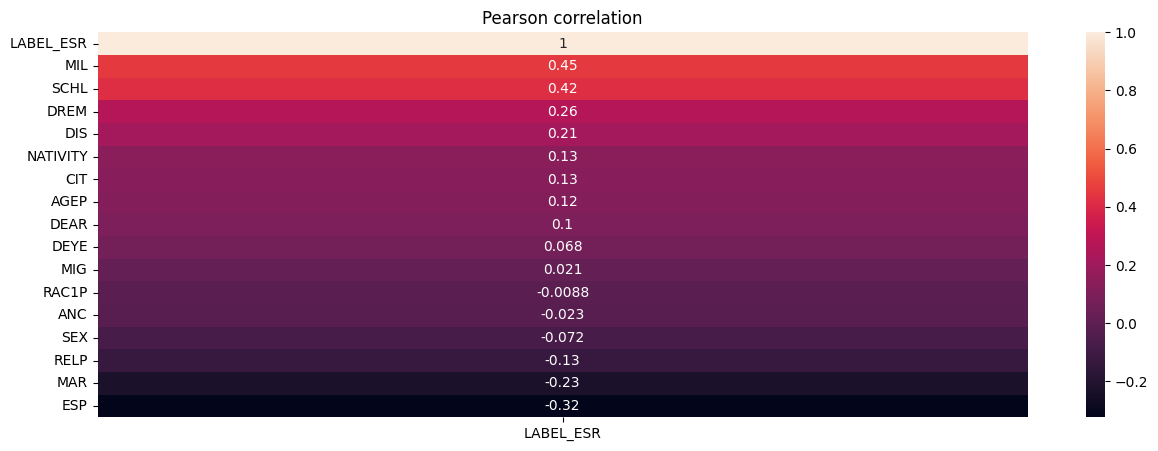

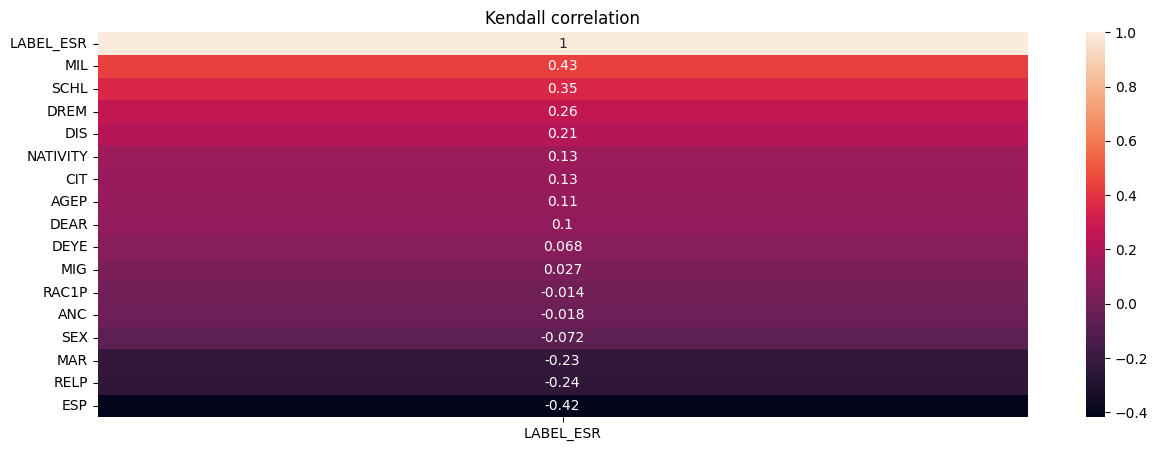

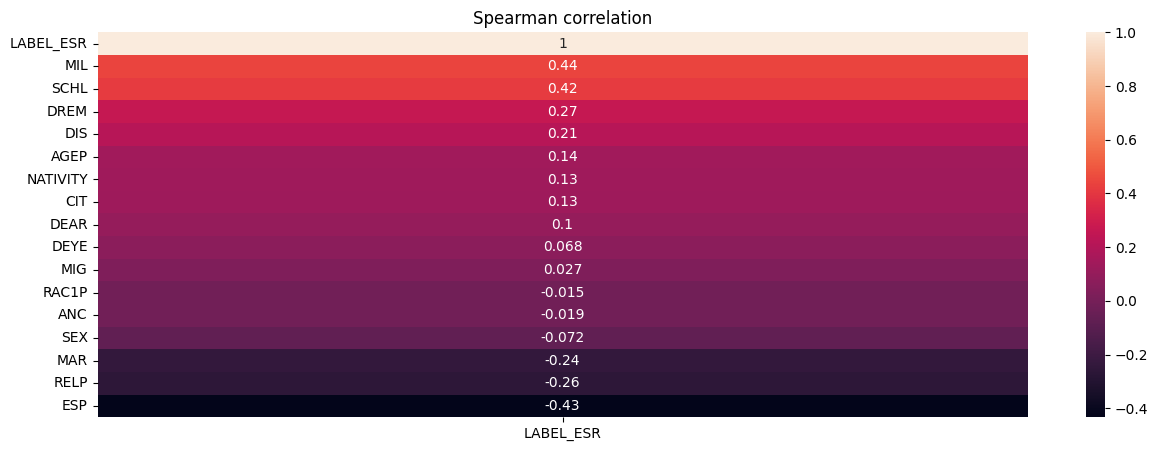

In [102]:
# Look at the feature correlation with 'LABEL_ESR' column
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(
        full_df.corr(method=method)[['LABEL_ESR']]\
            .sort_values(by='LABEL_ESR', ascending=False),
        ax=ax,
        annot=True
    )
    ax.set_title(f'{method.capitalize()} correlation')
    plt.show()


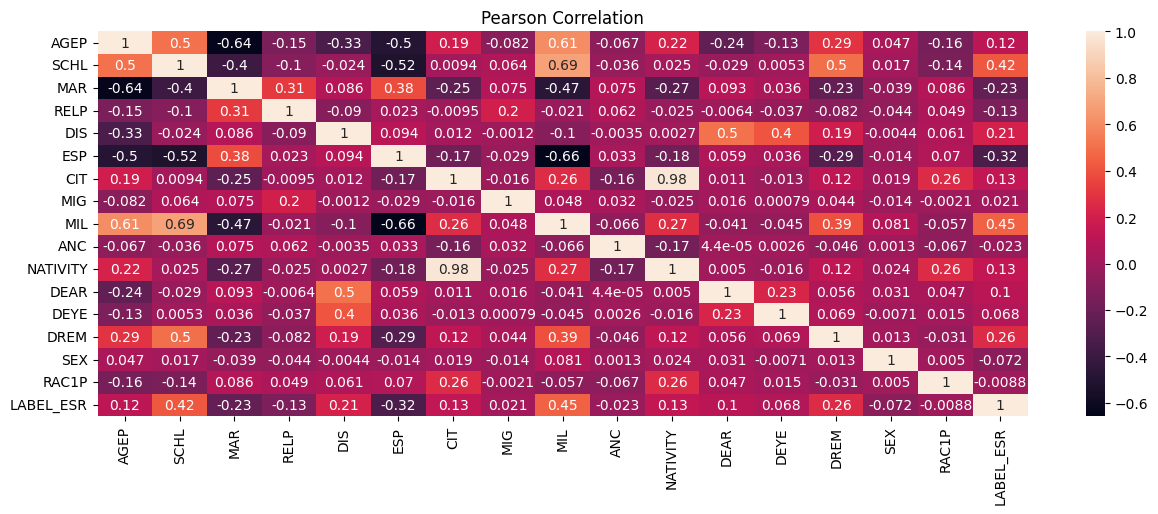

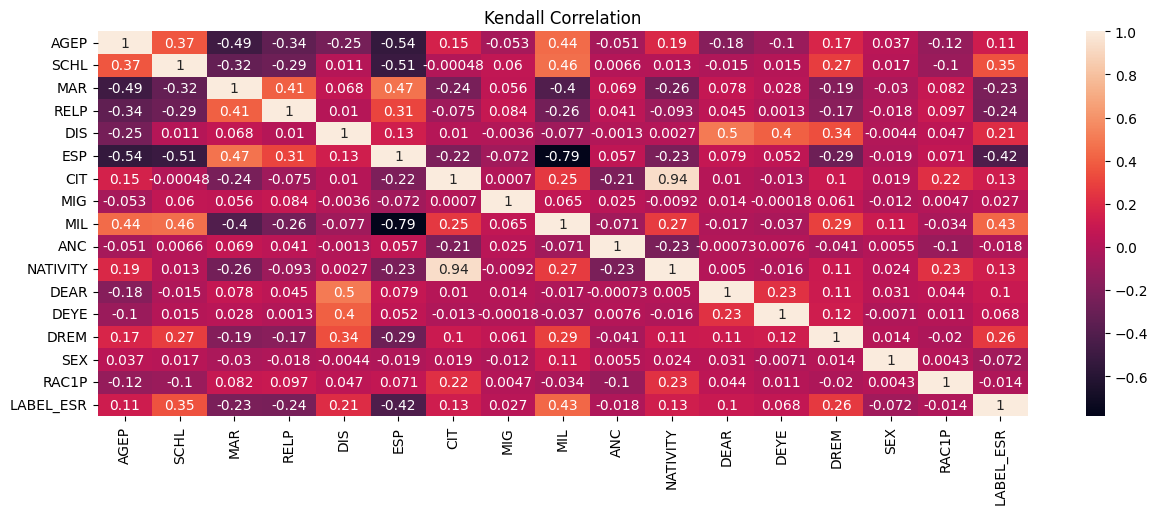

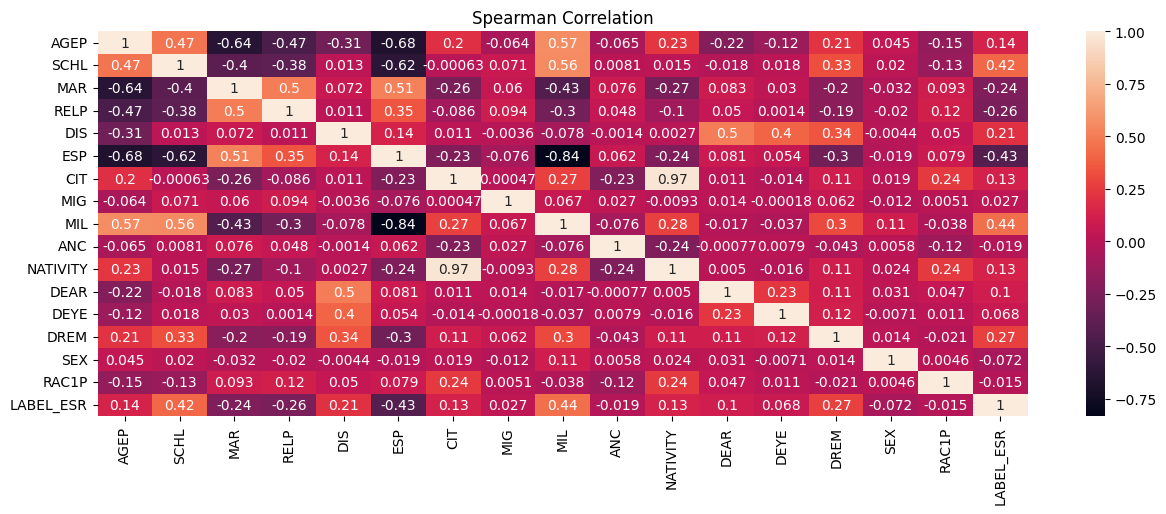

In [103]:
# Look at correlations among features
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(full_df.corr(method=method), ax=ax, annot=True)
    ax.set_title(f'{method.capitalize()} Correlation')
    plt.show()


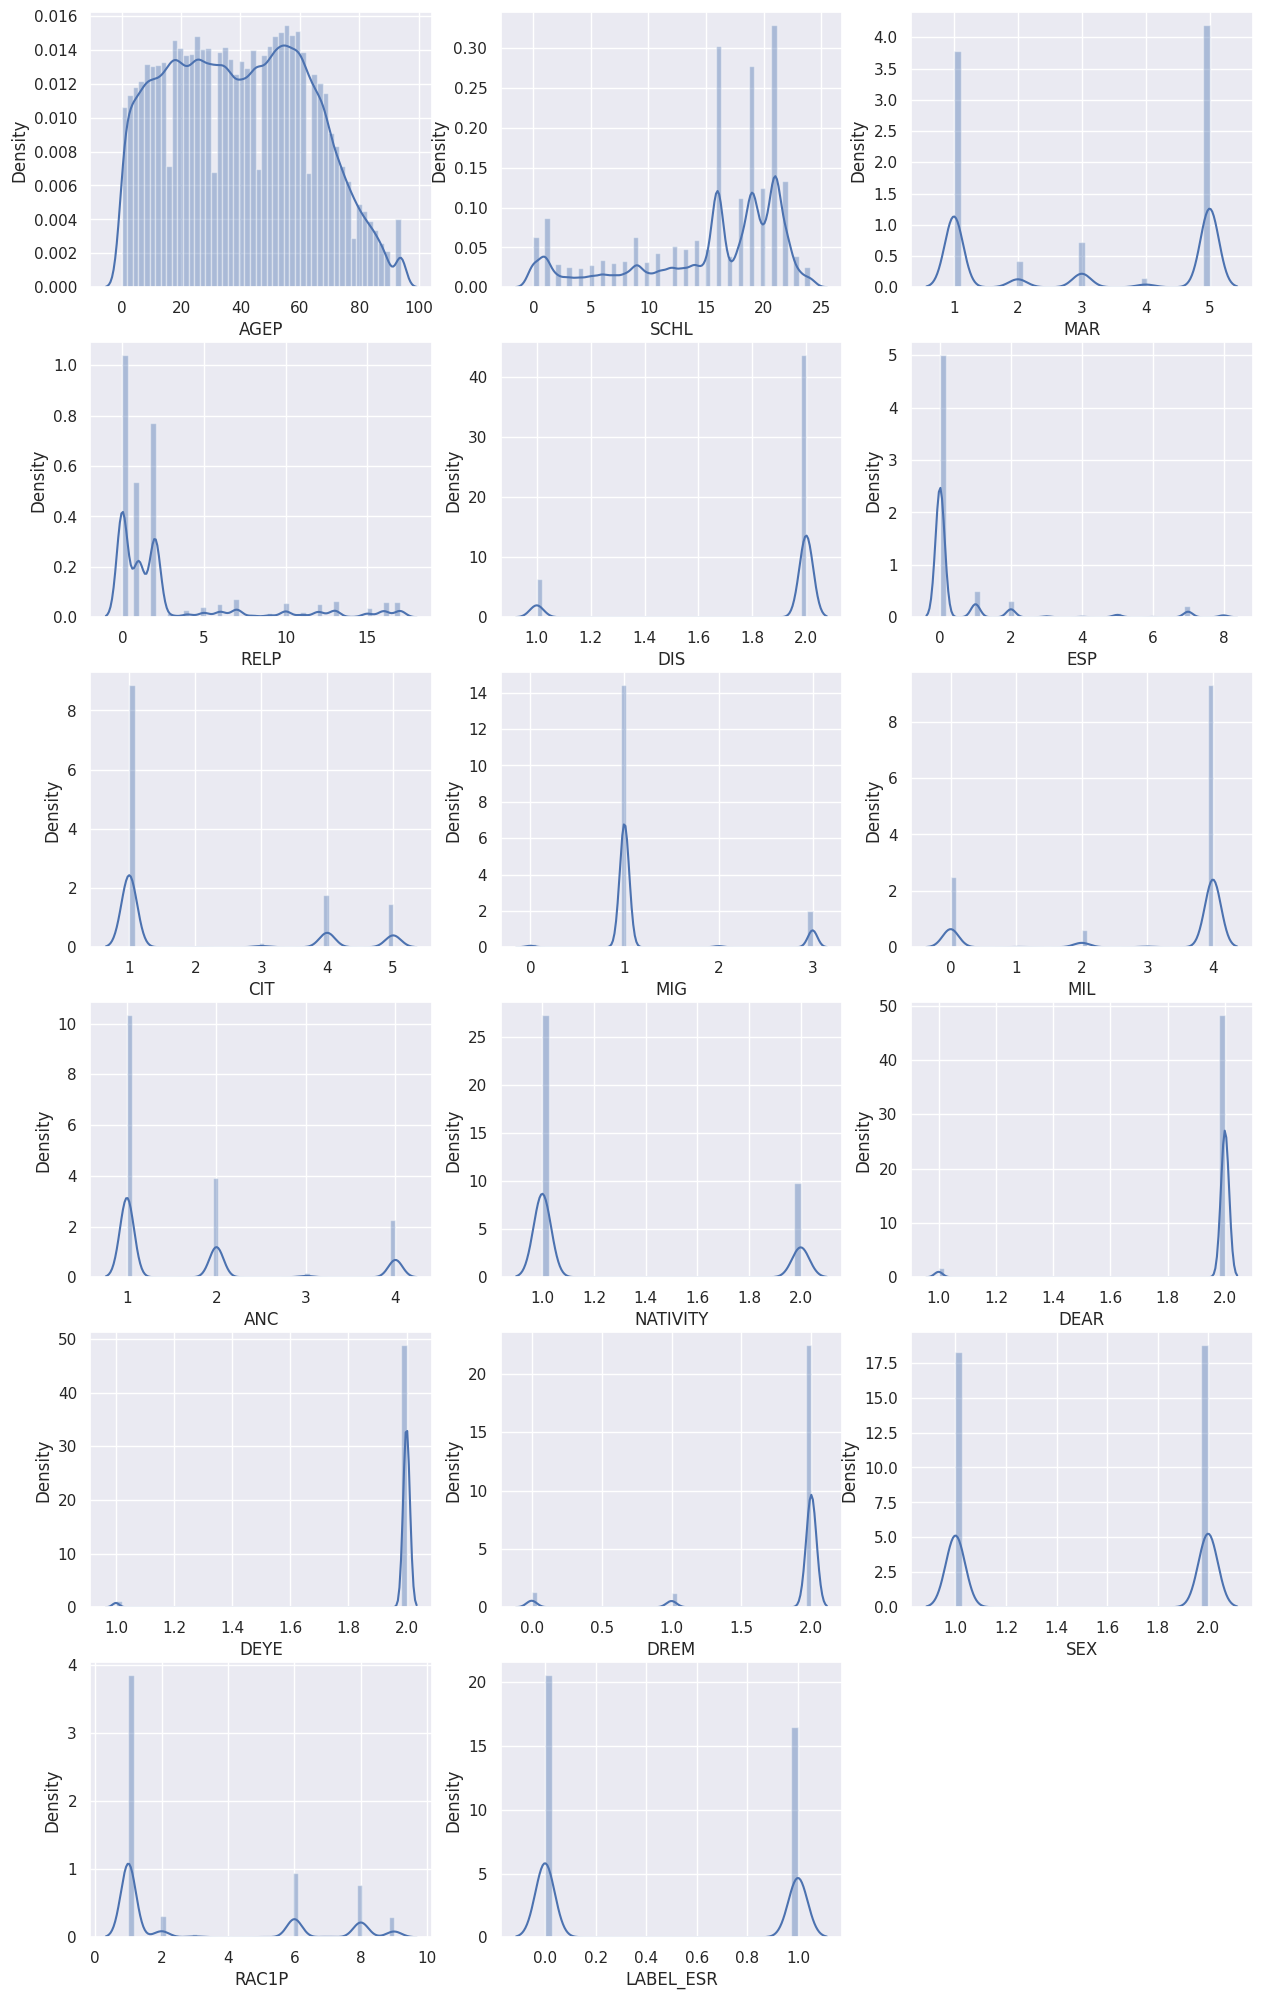

In [128]:
# Look at densities of each column
sns_set_size(height=25, width=15)

fig = plt.figure()
gs0 = matplotlib.gridspec.GridSpec(ncols=3, nrows=6, figure=fig)
for idx, column in enumerate(full_df.columns):
    n_row, n_col = divmod(idx, 3)
    ax = fig.add_subplot(gs0[n_row, n_col])
    sns.distplot(full_df[column], ax=ax)

set_default_plot_properties()

### Group Data By Race

In [17]:
full_df[full_df['SCHL'] == 0].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,LABEL_ESR
68,1,0.0,5,7,2,0.0,1,1.0,0.0,4,1,2,2,0.0,1,7,False
76,2,0.0,5,2,2,5.0,1,1.0,0.0,2,1,2,2,0.0,1,1,False
88,1,0.0,5,2,2,1.0,1,3.0,0.0,2,1,2,2,0.0,1,1,False
264,2,0.0,5,7,2,7.0,1,1.0,0.0,1,1,2,2,0.0,2,1,False
269,2,0.0,5,2,2,1.0,1,1.0,0.0,4,1,2,2,0.0,1,1,False


In [13]:
def plot_column_grouped_by_race_nulls(plot_column):
    sns_set_size(height=18, width=15)

    fig = plt.figure()
    gs0 = matplotlib.gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    race_names = ['White alone', 'Black or African American alone', 'American Indian alone',
                  'Alaska Native alone', 'American Indian', 'Asian alone',
                  'Hawaiian and Other Pacific Islander alone', 'Some Other Race alone', 'Two or More Races']

    for i in range(len(race_names)):
        n_row, n_col = divmod(i, 3)
        ax = fig.add_subplot(gs0[n_row, n_col])
        ax.set_title(race_names[i])
        sns.distplot(full_df[full_df[plot_column] == 0][full_df['RAC1P'] == i + 1][plot_column], ax=ax)

    set_default_plot_properties()

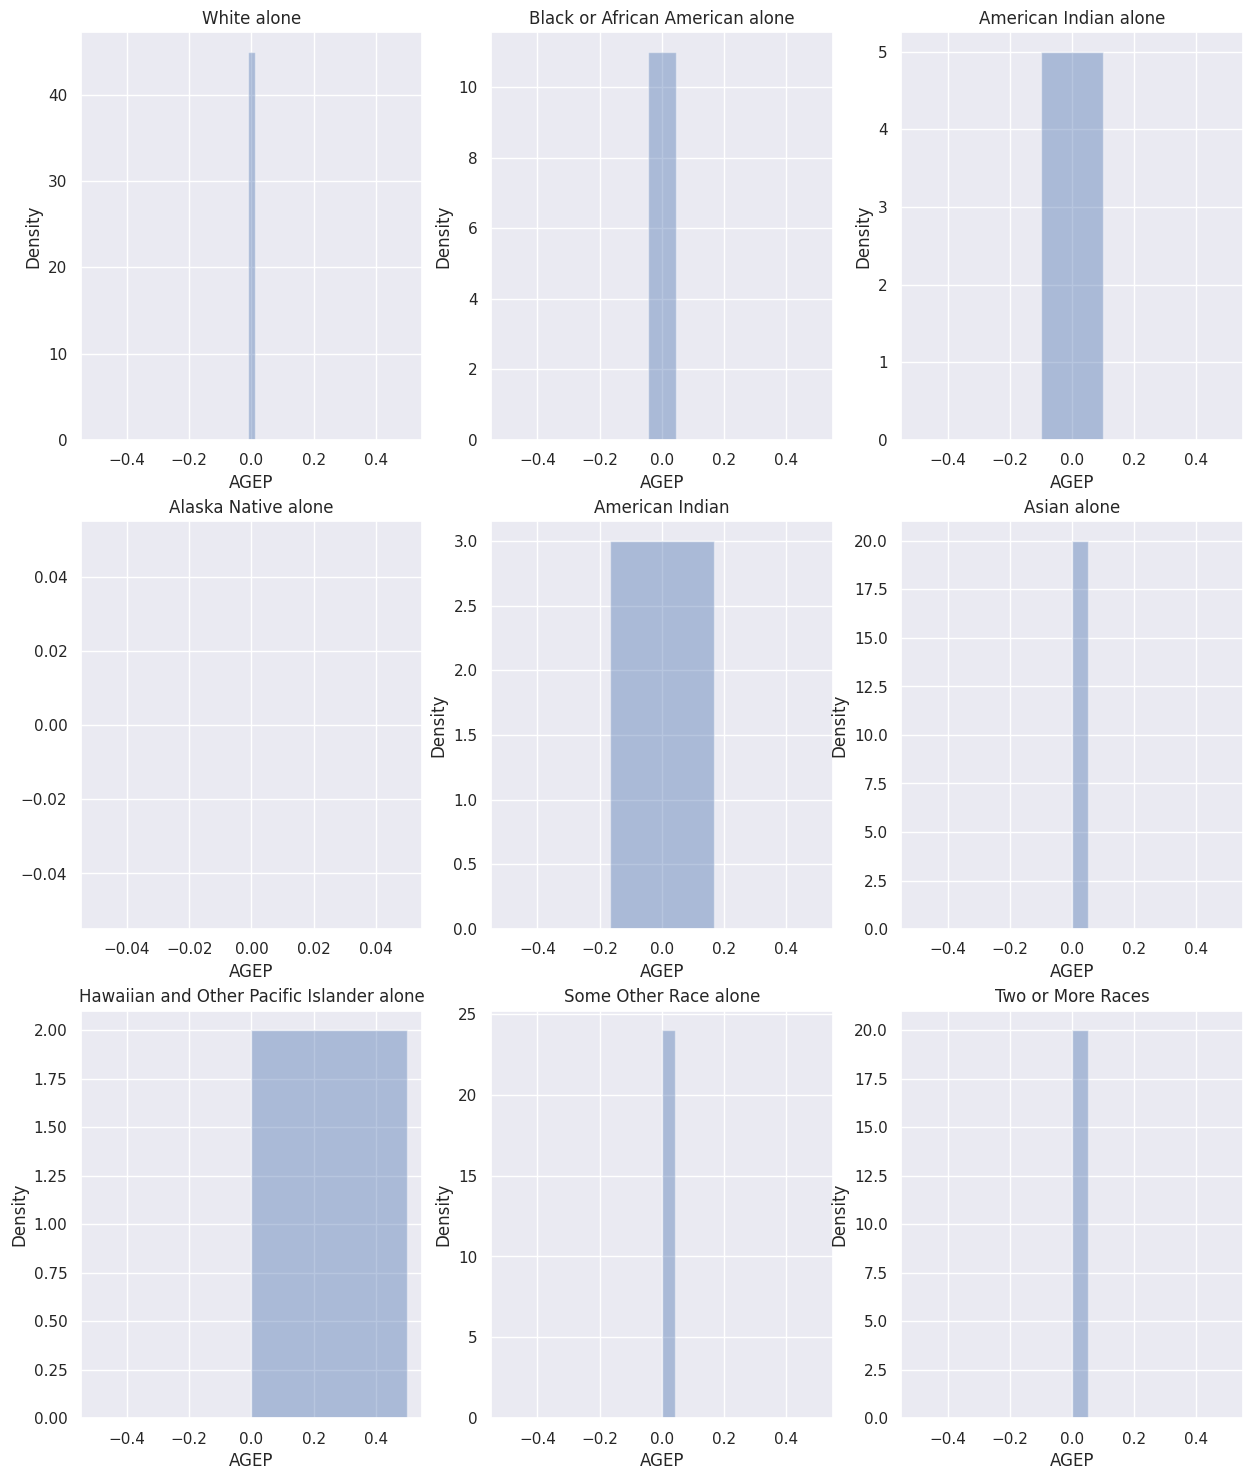

In [14]:
plot_column_grouped_by_race_nulls('AGEP')

In [129]:
def plot_column_grouped_by_race(plot_column):
    sns_set_size(height=18, width=15)

    fig = plt.figure()
    gs0 = matplotlib.gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    race_names = ['White alone', 'Black or African American alone', 'American Indian alone',
                  'Alaska Native alone', 'American Indian', 'Asian alone',
                  'Hawaiian and Other Pacific Islander alone', 'Some Other Race alone', 'Two or More Races']

    for i in range(len(race_names)):
        n_row, n_col = divmod(i, 3)
        ax = fig.add_subplot(gs0[n_row, n_col])
        ax.set_title(race_names[i])
        sns.distplot(full_df[full_df['RAC1P'] == i + 1][plot_column], ax=ax)

    set_default_plot_properties()


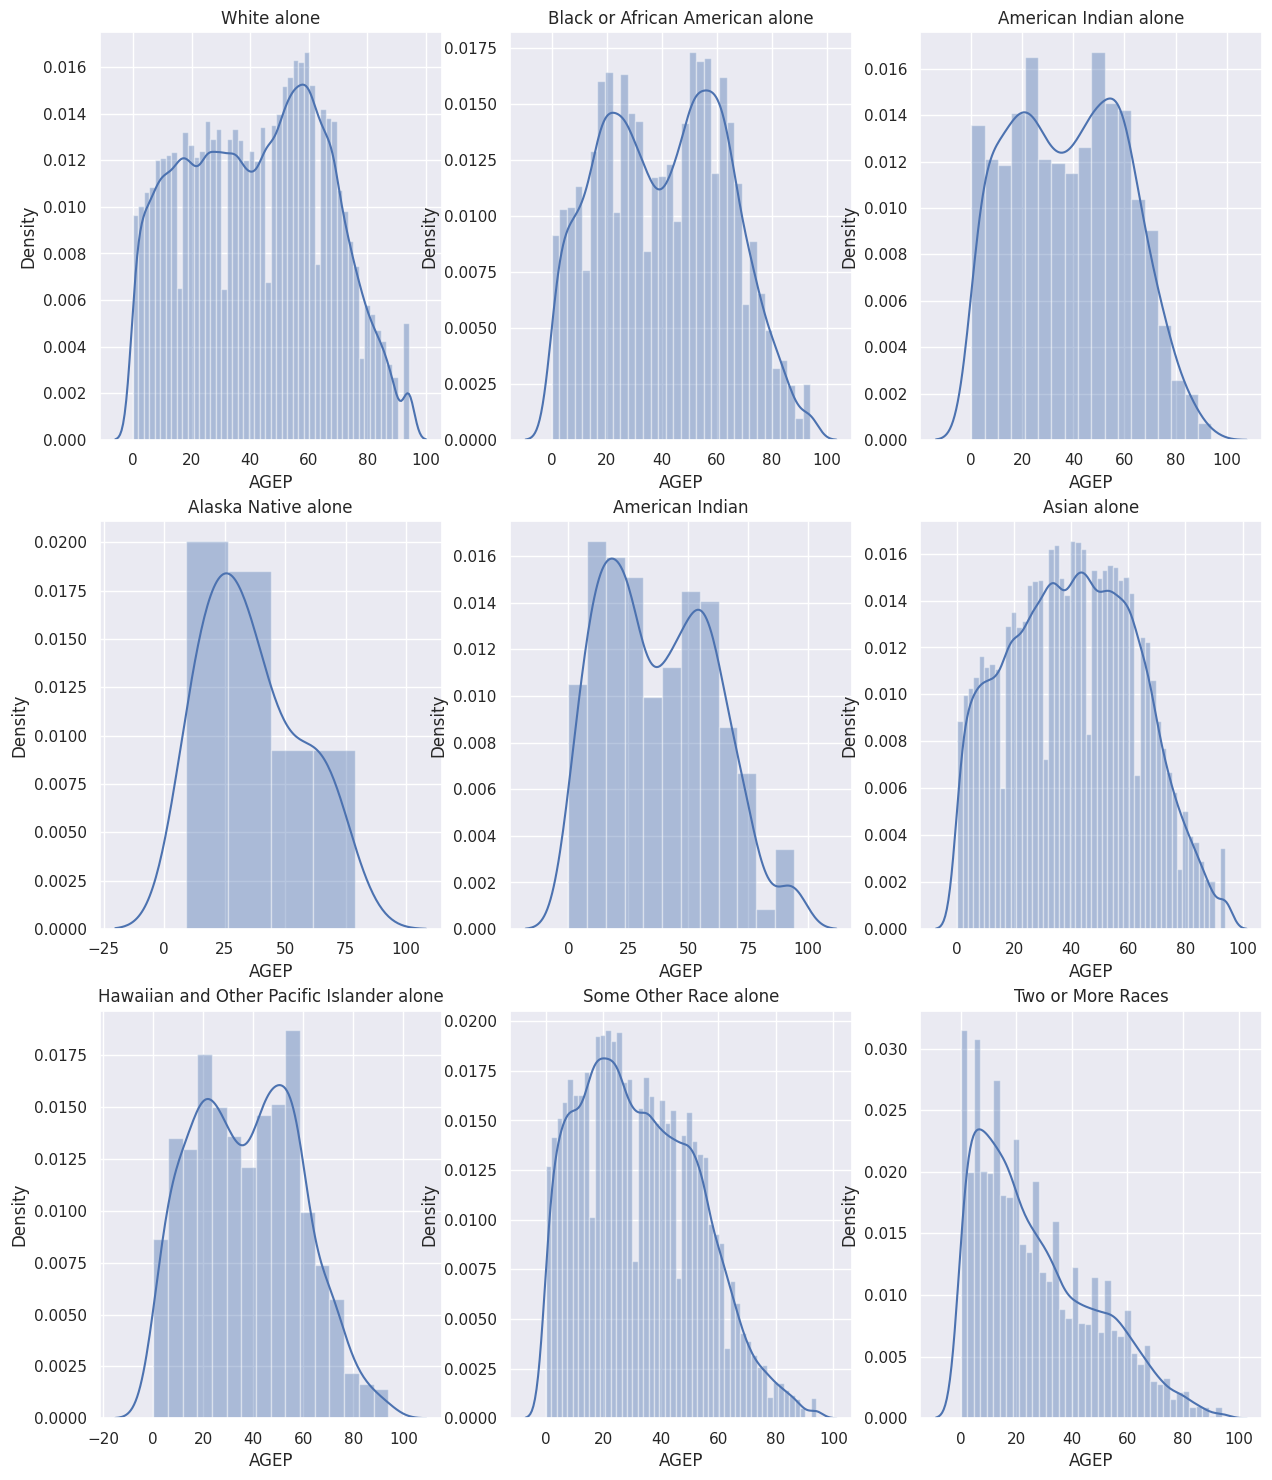

In [106]:
plot_column_grouped_by_race(plot_column='AGEP')

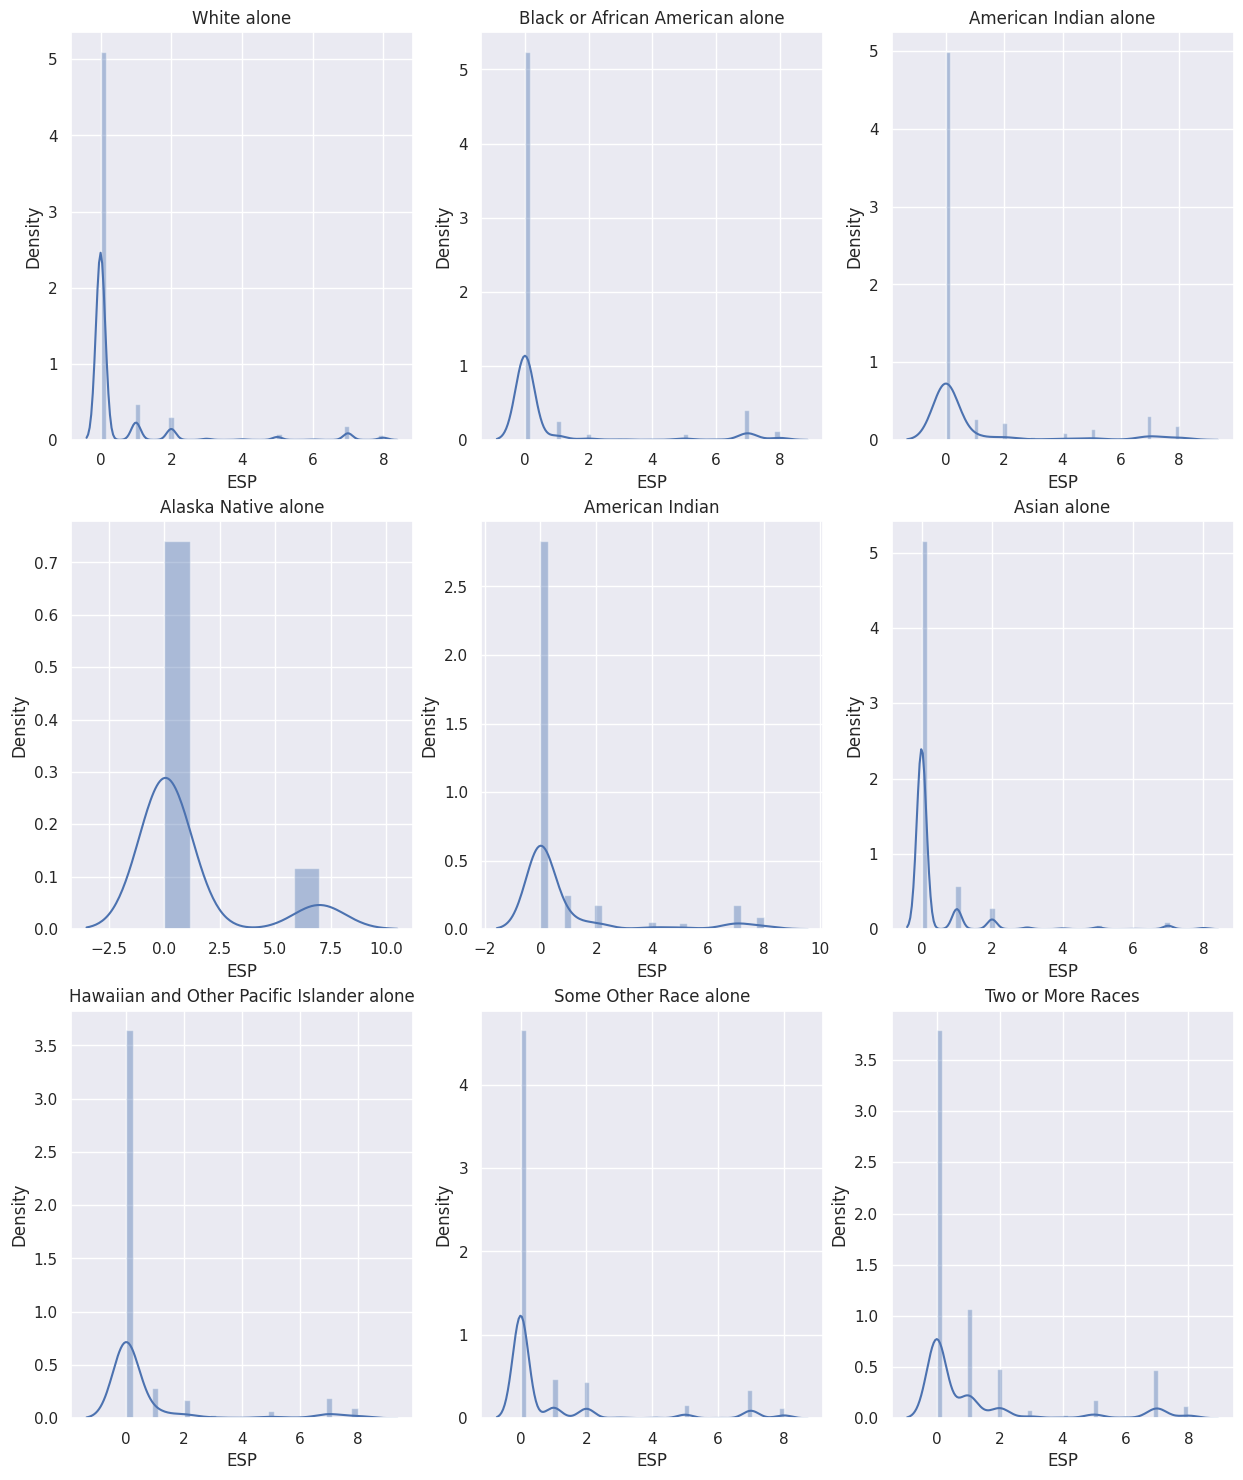

In [107]:
plot_column_grouped_by_race(plot_column='ESP')

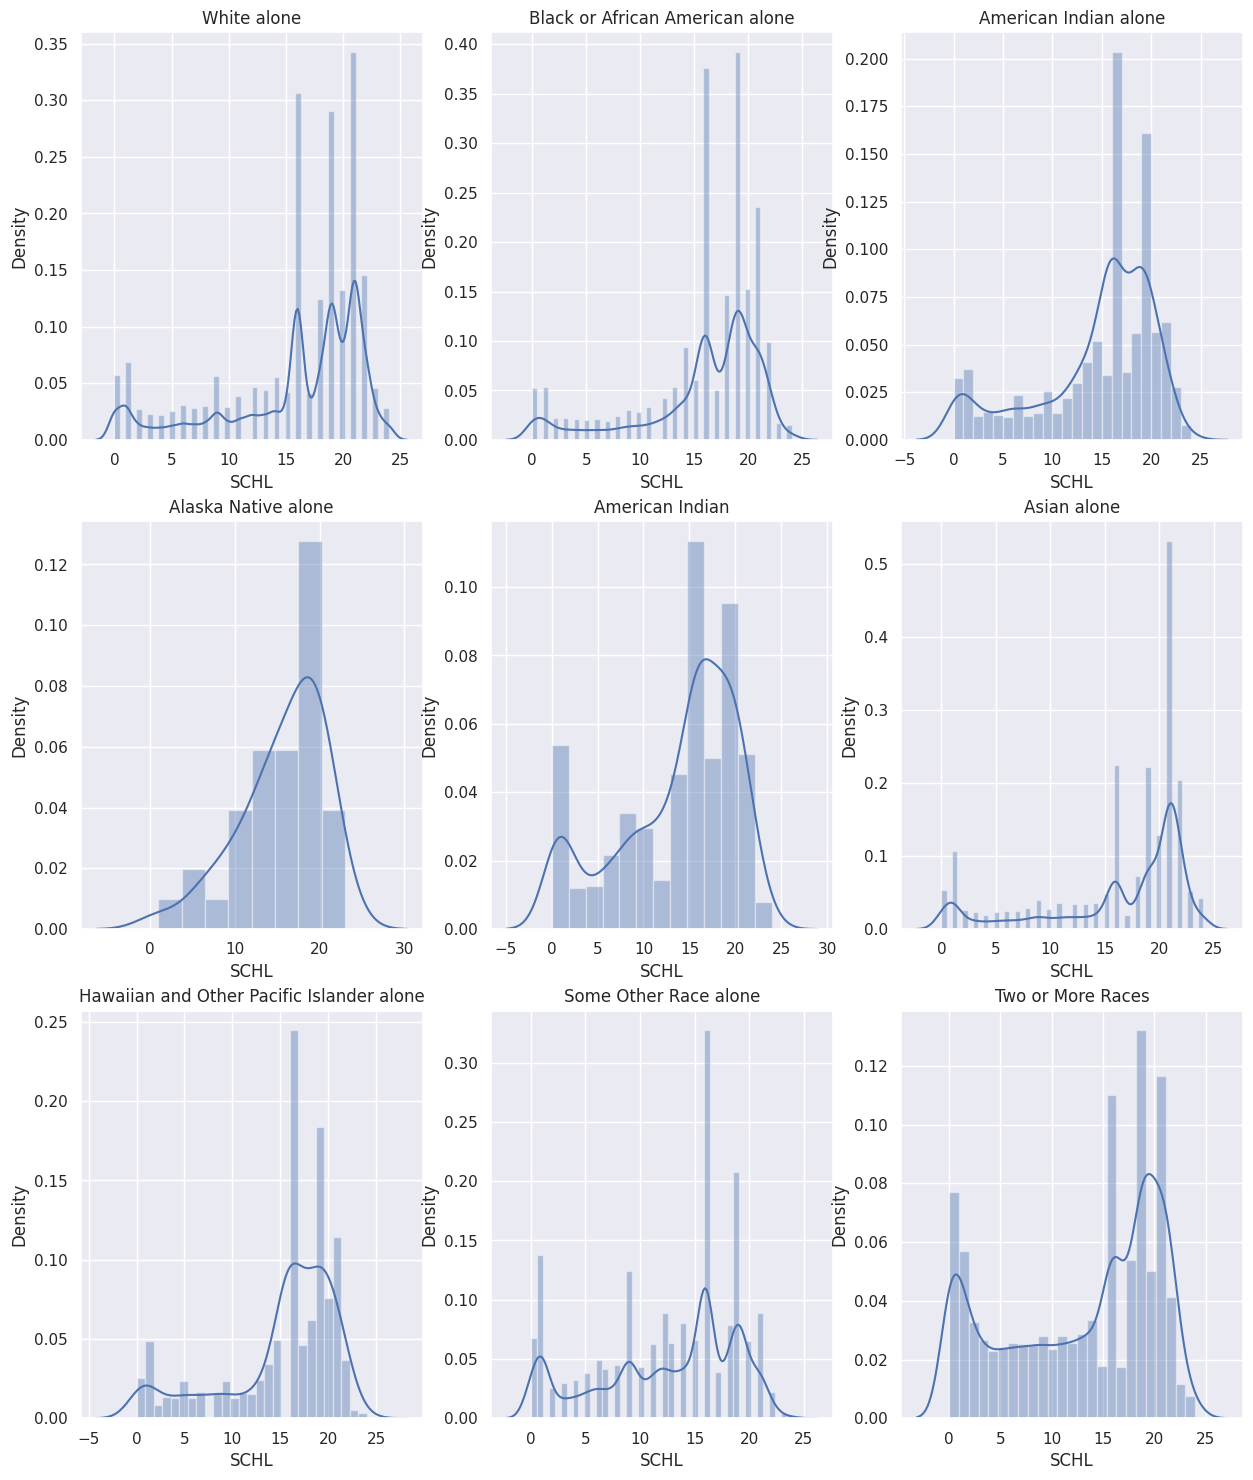

In [130]:
plot_column_grouped_by_race(plot_column='SCHL')

### Analyze Feature Importance

In [131]:
SEED = 42
features_df = full_df.drop('LABEL_ESR', axis=1, inplace=False)
target_df = full_df['LABEL_ESR']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
X_train_full.shape, X_test_full.shape

((300828, 16), (75207, 16))

Text(0.5, 0, 'Random Forest Feature Importance')

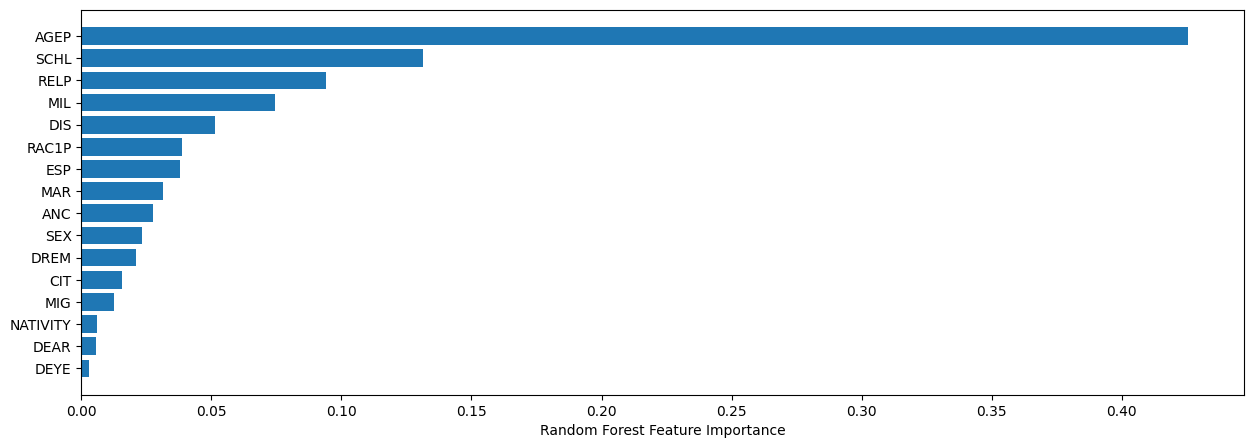

In [132]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_full, y_train_full)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(features_df.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Correlation Analysis after One-Hot Encoding

In [111]:
feature_analysis_cols = [col for col in full_df.columns if col not in ['AGEP', 'SCHL']]
features_analysis_df = pd.get_dummies(full_df[feature_analysis_cols], columns=feature_analysis_cols)
features_analysis_df['AGEP'] = full_df['AGEP']
features_analysis_df['SCHL'] = full_df['SCHL']
features_analysis_df['LABEL_ESR'] = full_df['LABEL_ESR']
features_analysis_df.head()

,MAR_1,MAR_2,MAR_3,MAR_4,MAR_5,RELP_0,RELP_1,RELP_2,RELP_3,RELP_4,...,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,LABEL_ESR_False,LABEL_ESR_True,AGEP,SCHL,LABEL_ESR
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,68,20.0,False
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,75,18.0,False
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,50,19.0,True
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,49,16.0,True
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,1,0,22,18.0,False


In [112]:
features_analysis_df.columns

Index(['MAR_1', 'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'RELP_0', 'RELP_1',
       'RELP_2', 'RELP_3', 'RELP_4', 'RELP_5', 'RELP_6', 'RELP_7', 'RELP_8',
       'RELP_9', 'RELP_10', 'RELP_11', 'RELP_12', 'RELP_13', 'RELP_14',
       'RELP_15', 'RELP_16', 'RELP_17', 'DIS_1', 'DIS_2', 'ESP_0.0', 'ESP_1.0',
       'ESP_2.0', 'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0', 'ESP_7.0',
       'ESP_8.0', 'CIT_1', 'CIT_2', 'CIT_3', 'CIT_4', 'CIT_5', 'MIG_0.0',
       'MIG_1.0', 'MIG_2.0', 'MIG_3.0', 'MIL_0.0', 'MIL_1.0', 'MIL_2.0',
       'MIL_3.0', 'MIL_4.0', 'ANC_1', 'ANC_2', 'ANC_3', 'ANC_4', 'NATIVITY_1',
       'NATIVITY_2', 'DEAR_1', 'DEAR_2', 'DEYE_1', 'DEYE_2', 'DREM_0.0',
       'DREM_1.0', 'DREM_2.0', 'SEX_1', 'SEX_2', 'RAC1P_1', 'RAC1P_2',
       'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8',
       'RAC1P_9', 'LABEL_ESR_False', 'LABEL_ESR_True', 'AGEP', 'SCHL',
       'LABEL_ESR'],
      dtype='object')

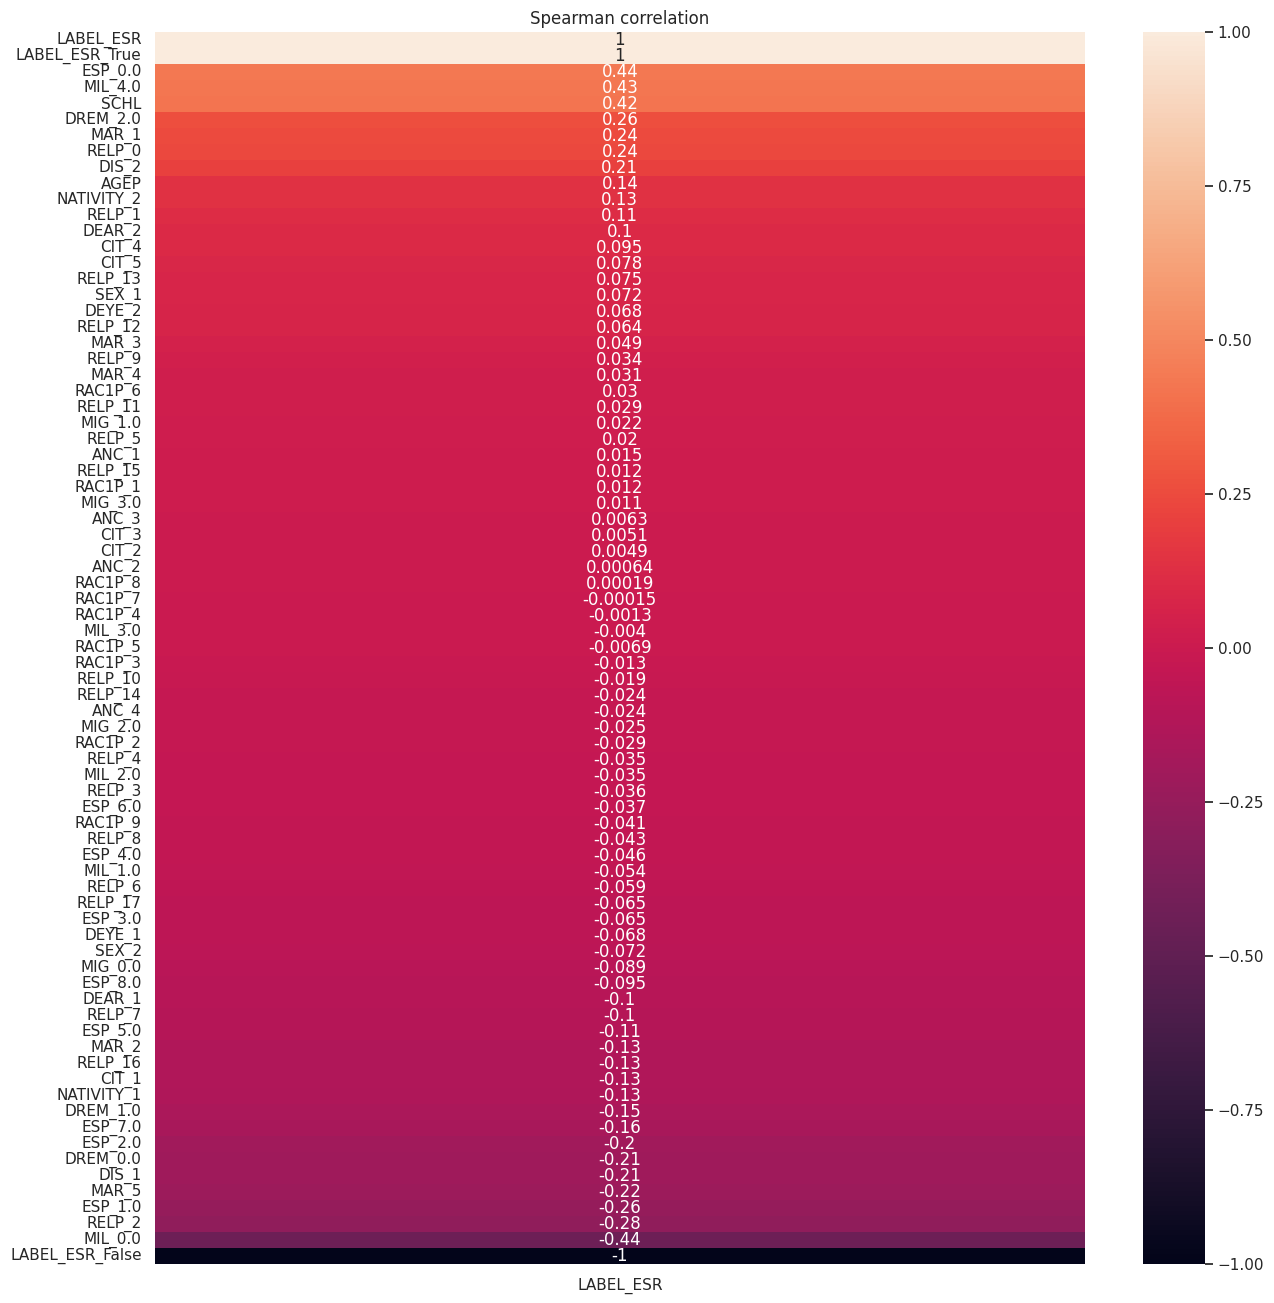

In [113]:
# Look at the feature correlation with 'LABEL_ESR' column
sns_set_size(height=16, width=15)
for method in ['spearman']:
    ax = plt.axes()
    sns.heatmap(
        features_analysis_df.corr(method=method)[['LABEL_ESR']]
            .sort_values(by='LABEL_ESR', ascending=False),
        ax=ax,
        annot=True
    )
    ax.set_title(f'{method.capitalize()} correlation')
    plt.show()

set_default_plot_properties()

In [114]:
def get_column_correlations(column_list):
    for method in ['spearman']:
        ax = plt.axes()
        sns.heatmap(features_analysis_df[column_list].corr(method=method), ax=ax, annot=True)
        ax.set_title(f'{method.capitalize()} Correlation')
        plt.show()

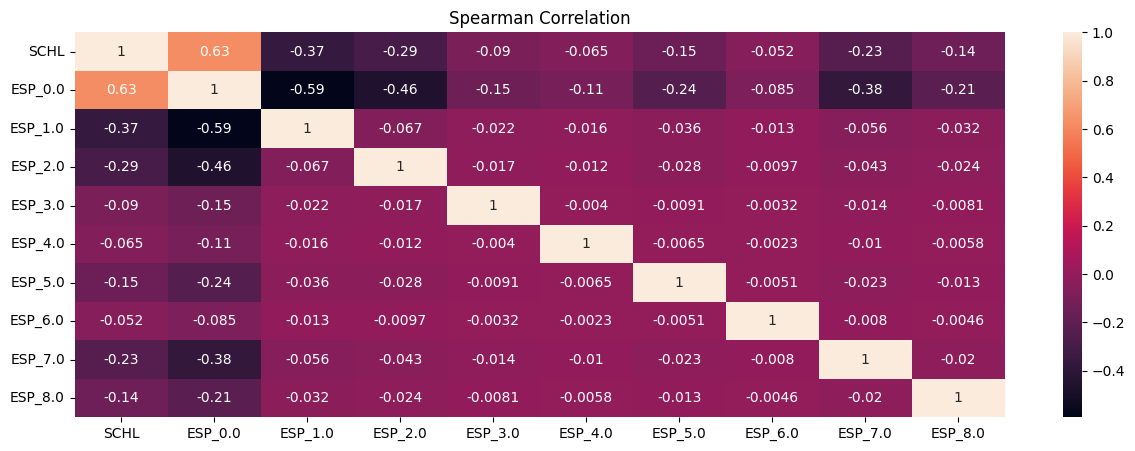

In [115]:
get_column_correlations(['SCHL', 'ESP_0.0', 'ESP_1.0', 'ESP_2.0', 'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0', 'ESP_7.0', 'ESP_8.0'])

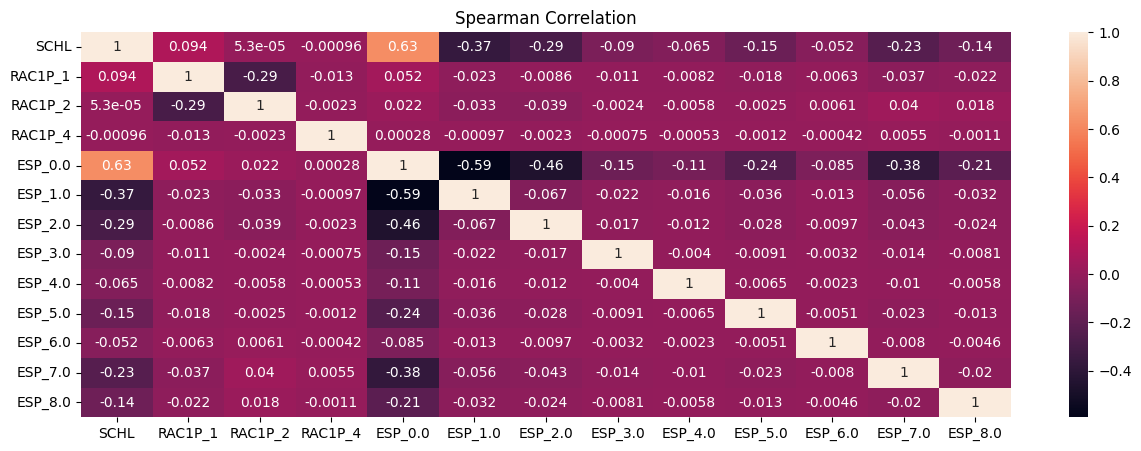

In [116]:
get_column_correlations(['SCHL', 'RAC1P_1', 'RAC1P_2', 'RAC1P_4', 'ESP_0.0', 'ESP_1.0',
                         'ESP_2.0', 'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0', 'ESP_7.0', 'ESP_8.0'])

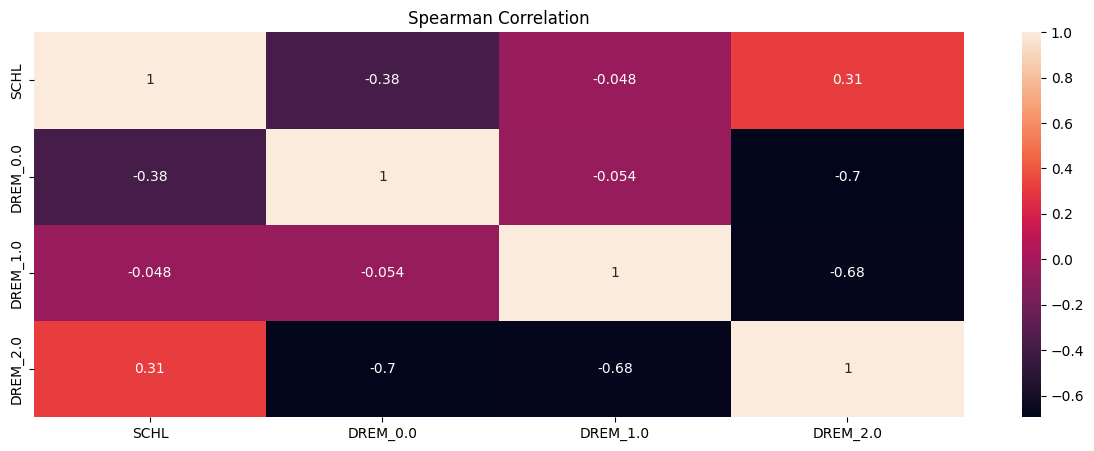

In [117]:
get_column_correlations(['SCHL', 'DREM_0.0', 'DREM_1.0', 'DREM_2.0'])

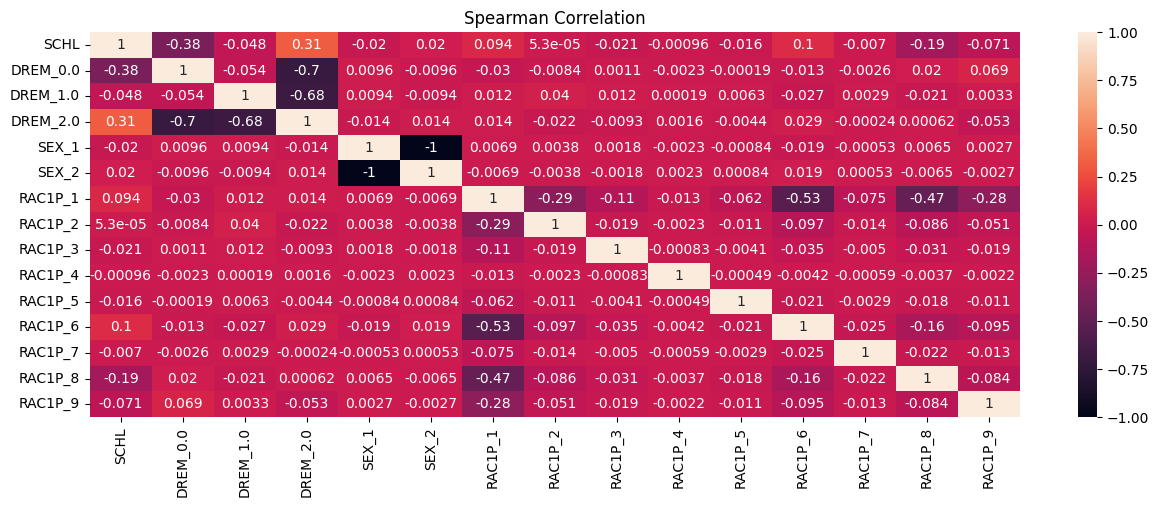

In [118]:
get_column_correlations(['SCHL', 'DREM_0.0', 'DREM_1.0', 'DREM_2.0', 'SEX_1', 'SEX_2', 'RAC1P_1', 'RAC1P_2',
                          'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8', 'RAC1P_9'])

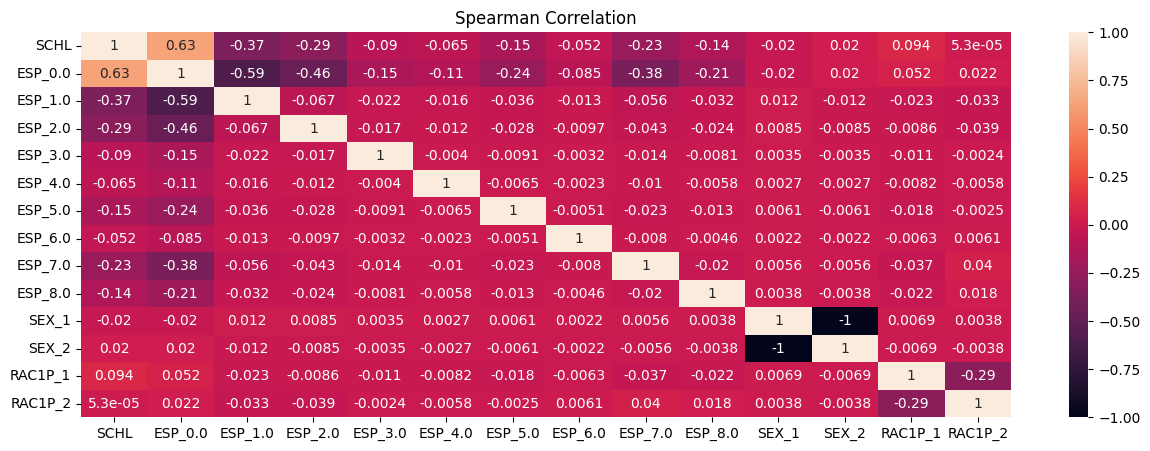

In [119]:
get_column_correlations(['SCHL', 'ESP_0.0', 'ESP_1.0', 'ESP_2.0', 'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0',
                         'ESP_7.0','ESP_8.0', 'SEX_1', 'SEX_2', 'RAC1P_1', 'RAC1P_2'])

### Train a baseline model

In [ ]:
# Create a feature dataframe based on the feature correlation with 'LABEL_ESR' and feature importance
feature_cols = ['MIL', 'DIS', 'ESP', 'MAR', 'RELP', 'ANC']
features_df = pd.get_dummies(full_df[feature_cols], columns=feature_cols)
features_df['AGEP'] = full_df['AGEP']
features_df['SCHL'] = full_df['SCHL']
target_df = full_df['LABEL_ESR']
features_df.head()

In [ ]:
features_df.columns

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape

((300828, 45), (75207, 45))

In [23]:
n_folds = 3
samples_per_fold = len(y_test)
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [26]:
config_models = [
    {
        'model_name': 'RandomForestClassifier',
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            "bootstrap": [True],
            "max_depth": [10],
            "n_estimators": [30],
            "max_features": [0.6]
        }
    },
    {
        'model_name': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            "max_depth": [10],
            "max_features": [0.6],
            "criterion": ["gini"]
        }
    },
    # For XGBoost parameters tuning we used this article --
    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    {
        'model_name': 'XGBClassifier',
        'model': XGBClassifier(random_state=SEED),
        'params': {
            'learning_rate': [0.1],
            'n_estimators': [200],
            'max_depth': [5],
            'objective':  ['binary:logistic'],
        }
    }
]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning for RandomForestClassifier is finished
####################  Folktables [LA]  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 30}

              precision    recall  f1-score   support

       False      0.884     0.759     0.817     41736
        True      0.745     0.876     0.805     33471

    accuracy                          0.811     75207
   macro avg      0.814     0.818     0.811     75207
weighted avg      0.822     0.811     0.812     75207



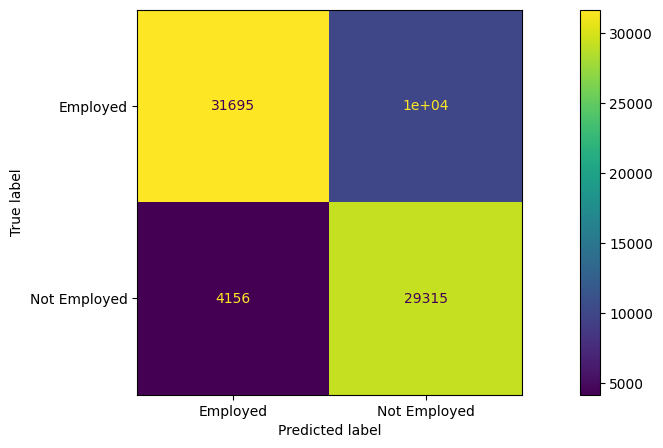

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning for DecisionTreeClassifier is finished
####################  Folktables [LA]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.6}

              precision    recall  f1-score   support

       False      0.884     0.758     0.816     41736
        True      0.744     0.876     0.804     33471

    accuracy                          0.811     75207
   macro avg      0.814     0.817     0.810     75207
weighted avg      0.822     0.811     0.811     75207



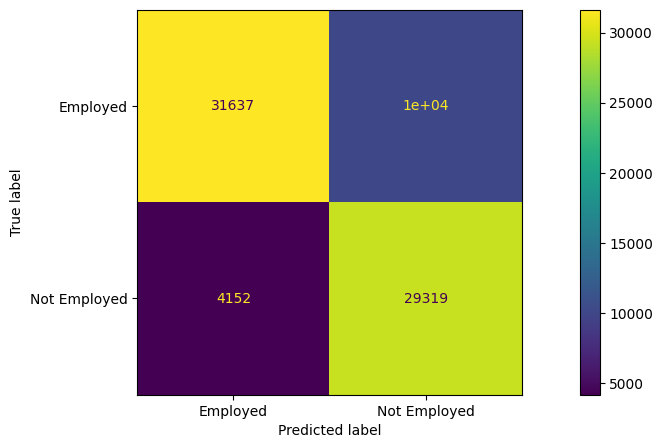

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Tuning for XGBClassifier is finished
####################  Folktables [LA]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

       False      0.883     0.762     0.818     41736
        True      0.746     0.874     0.805     33471

    accuracy                          0.812     75207
   macro avg      0.815     0.818     0.811     75207
weighted avg      0.822     0.812     0.812     75207



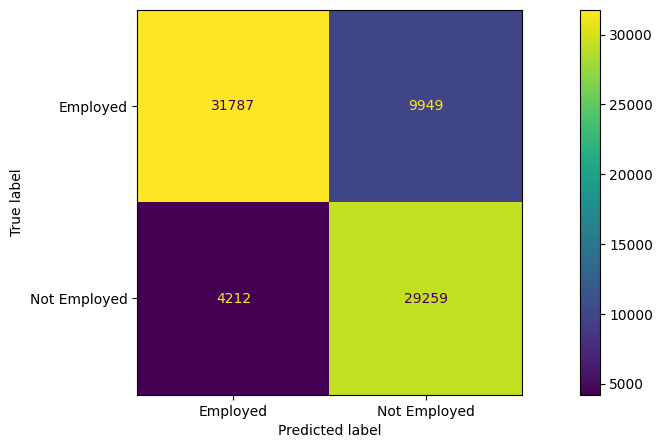

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [LA],RandomForestClassifier,0.811038,0.811228,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,Folktables [LA],DecisionTreeClassifier,0.810329,0.810510,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,Folktables [LA],XGBClassifier,0.811493,0.811706,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [27]:
ML_results_df = test_ML_models(best_results_df, config_models, n_folds, samples_per_fold,
                               X_train, y_train, X_test, y_test, "Folktables [LA]", show_plots=True, debug_mode=True)
ML_results_df

In [28]:
for index, row in ML_results_df.iterrows():
  print(f'\n\nModel name: {row["Model_Name"]}')
  pprint(row['Model_Best_Params'])



Model name: RandomForestClassifier
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 30}


Model name: DecisionTreeClassifier
{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.6}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}
